In [1]:
import cv2
import mahotas as mh
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class DetectionofCopyMoveForgery:

    def __init__(self, img, height, width, blocksize, order, oklid_threshold, correlation_threshold, vec_len_threshold, num_ofvector_threshold):
        self.img = img
        self.height = height
        self.width = width
        self.blocksize = blocksize
        self.oklid_threshold = oklid_threshold
        self.correlation_threshold = correlation_threshold
        self.vec_len_threshold = vec_len_threshold
        self.num_ofvector_threshold = num_ofvector_threshold

        self.block_vector = []
        self.sizeof_vector = 10  # Zernike Moment có 5 giá trị
        self.zernike_order = order  # Zernike moment order
        self.hough_space = np.zeros((self.height, self.width, 2))
        self.shiftvector = []

    def detection_forgery(self):
        self.zernike_moments_of_img()
        self.lexicographically_sort_of_vectors()
        self.correlation_of_vectors()

        max = -1
        for i in range(self.height):
            for j in range(self.width):
                for h in range(2):
                    if (self.hough_space[i][j][h]) > max:
                        max = self.hough_space[i][j][h]
        for i in range(self.height):
            for j in range(self.width):
                self.img[i][j] = 0

        for i in range(self.height):
            for j in range(self.width):
                for h in range(2):
                    if (self.hough_space[i][j][h]) >= (max - (max * self.num_ofvector_threshold / 100)):
                        for k in range(len(self.shiftvector)):
                            if (self.shiftvector[k][0] == j and self.shiftvector[k][1] == i and self.shiftvector[k][2] == h):
                                cv2.rectangle(self.img, (int(self.shiftvector[k][3]), int(self.shiftvector[k][4])),
                                              (int(self.shiftvector[k][3] + self.blocksize), int(self.shiftvector[k][4] + self.blocksize)),
                                              (255), -1)
                                cv2.rectangle(self.img, (int(self.shiftvector[k][5]), int(self.shiftvector[k][6])),
                                              (int(self.shiftvector[k][5] + self.blocksize), int(self.shiftvector[k][6] + self.blocksize)),
                                              (255), -1)
        #cv2.imshow("sonuc", self.img)

    def zernike_moments_of_img(self):
        for r in range(0, self.height - self.blocksize, 1):
            for c in range(0, self.width - self.blocksize, 1):
                block = self.img[r:r + self.blocksize, c:c + self.blocksize]
                # Chuyển đổi block thành hình ảnh nhị phân (nếu cần)
                _, block = cv2.threshold(block, 127, 255, cv2.THRESH_BINARY)
                # Tính toán Zernike Moments cho block
                moments = mh.features.zernike_moments(block, radius=self.blocksize, degree=self.zernike_order)
                # Chỉ giữ lại 5 giá trị đầu tiên của Zernike Moments
                moments = moments[:self.sizeof_vector]
                moments = moments.tolist()
                #Thêm các thông tin về vị trí của block
                moments.append(c)
                moments.append(r)
                self.block_vector.append(moments)

    def lexicographically_sort_of_vectors(self):
        # Sắp xếp các vectơ dựa trên giá trị của chúng
        self.block_vector = np.array(self.block_vector)
        self.block_vector = self.block_vector[np.lexsort(np.rot90(self.block_vector)[2:(self.sizeof_vector + 1) + 2, :])]

    def correlation_of_vectors(self):
        for i in range(len(self.block_vector)):
            if (i + self.correlation_threshold >= len(self.block_vector)):
                self.correlation_threshold -= 1
            for j in range(i + 1, i + self.correlation_threshold + 1):
                if (self.oklid(self.block_vector[i][:self.sizeof_vector], self.block_vector[j][:self.sizeof_vector], self.sizeof_vector) <= self.oklid_threshold):
                    v1 = [self.block_vector[i][-2], self.block_vector[i][-1]]
                    v2 = [self.block_vector[j][-2], self.block_vector[j][-1]]
                    self.elimination_of_weak_vectors(v1, v2, 2)

    def elimination_of_weak_vectors(self, vector1, vector2, size):
        if (self.oklid(vector1, vector2, size) >= self.vec_len_threshold):
            self.elimination_of_weak_area(vector1, vector2)

    def elimination_of_weak_area(self, vector1, vector2):
        c = int(abs(vector2[0] - vector1[0]))
        r = int(abs(vector2[1] - vector1[1]))
        if (vector2[0] >= vector1[0]):
            if (vector2[1] >= vector1[1]):
                z = 0
            else:
                z = 1

        if (vector1[0] > vector2[0]):
            if (vector1[1] >= vector2[1]):

                z = 0
            else:
                z = 1
        self.hough_space[r][c][z] += 1
        vector = [c, r, z, vector1[0], vector1[1], vector2[0], vector2[1]]
        self.shiftvector.append(vector) 

    def oklid(self, vector1, vector2, size):
        sum = 0
        for i in range(size):
            sum += (vector2[i] - vector1[i]) ** 2

        return np.sqrt(sum)

In [3]:
image_path = "dataset/multi_paste/barrier_gcs500_copy_rb5.png"
img = cv2.imread(image_path, 0)

height, width= img.shape
block_size = 24 # Set your desired block_size
oklid_threshold = 3.5  # Set your desired oklid_threshold
correlation_threshold = 8  # Set your desired correlation_threshold
vec_len_threshold = 100  # Set your desired vec_len_threshold
num_ofvector_threshold = 5  # Set your desired num_ofvector_threshold
order =5 # Set your desired Zernike moment order

forgery_detector = DetectionofCopyMoveForgery(img, height, width, block_size, order, oklid_threshold, correlation_threshold, vec_len_threshold, num_ofvector_threshold)
forgery_detector.detection_forgery()

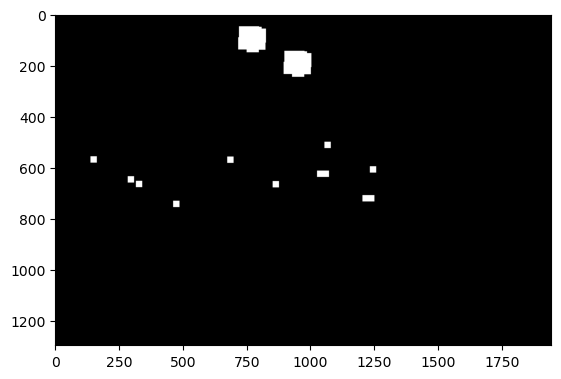

In [4]:
plt.imshow(img, cmap='gray')
plt.show()

In [5]:
def getFmeasure(orginal_img, test_img, width, height):
    DP=0
    YP=0
    YN=0
    for i in range(height):
        for j in range(width):
            if orginal_img[i][j]==255 and test_img[i][j]==255:
                DP +=1
            if orginal_img[i][j]==0 and test_img[i][j]==255:
                YP +=1
            if orginal_img[i][j]==255 and test_img[i][j]==0:
                YN +=1
    precision =DP/(DP+YP)
    recall =DP/(DP+YN)
    return 2*((precision*recall)/(precision+recall))

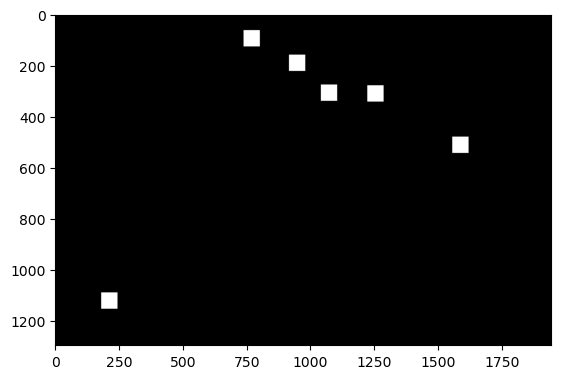

F1 score:  0.3141104294478528


In [6]:
original_img = cv2.imread("dataset/multi_paste/barrier_gcs500_gt_rb5.png",0)
plt.imshow(original_img, cmap='gray')
plt.show()

f1_score = getFmeasure(original_img,img,width,height) 
print("F1 score: ",f1_score)